# TP5 Méthode Auto-Encodeur Variationnel

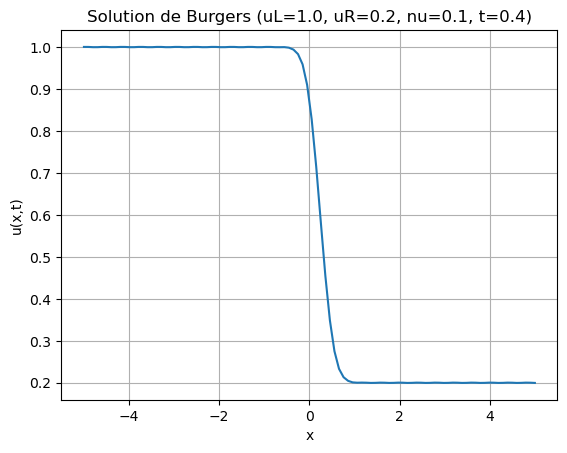

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

def solution_Burgers_visqueux(x, t, uL, uR, nu):
    nx = x.shape[0]
    y = torch.linspace(-20, 20, 100)
    dy = y[1] - y[0]

    G_y = torch.zeros_like(y)
    G_y[y<=0] = uL * y[y<=0]
    G_y[y>0] = uR * y[y>0]

    u_solution = torch.zeros_like(x)

    for i in range(nx):
        xi = x[i]
        exp_term = torch.exp(-((xi - y)**2) / (4 * nu * t) - G_y / (2 * nu))
        u_solution[i] = torch.sum(((xi - y) / t) * exp_term * dy) / torch.sum(exp_term * dy)

    return u_solution

def test_solution_burgers():
    x = torch.linspace(-5, 5, 100)
    t = 0.4
    uL = 1.0
    uR = 0.2
    nu = 0.1
    u = solution_Burgers_visqueux(x, t, uL, uR, nu)
    
    plt.figure()
    plt.plot(x.numpy(), u.numpy())
    plt.title(f"Solution de Burgers (uL={uL}, uR={uR}, nu={nu}, t={t})")
    plt.xlabel("x")
    plt.ylabel("u(x,t)")
    plt.grid(True)
    plt.show()

test_solution_burgers()

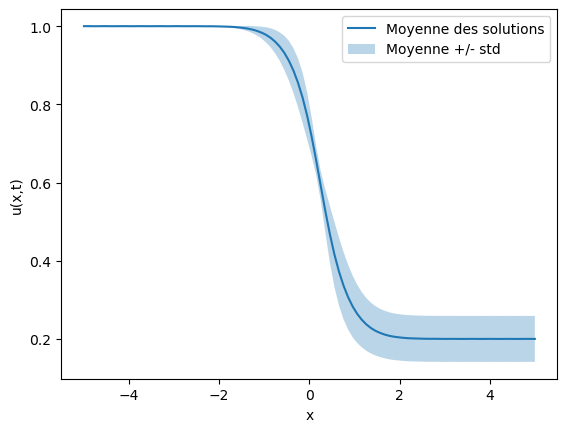

In [22]:
def generate_data(nb_data, nx, t):
    uL_fix = 1.0
    uR = torch.rand(nb_data) * (0.3 - 0.1) + 0.1
    nu = torch.rand(nb_data) * (1.0 - 0.05) + 0.05
    uL = torch.ones(nb_data) * uL_fix

    xmesh = torch.linspace(-5, 5, nx)
    u_data = torch.zeros((nb_data, nx))

    for i in range(nb_data):
        u_data[i, :] = solution_Burgers_visqueux(xmesh, t, uL[i], uR[i], nu[i])
    return uL, uR, nu, xmesh, u_data

def test_generate_data():
    nb_data = 100
    nx = 100
    t = 0.4
    uL, uR, nu, xmesh, u_data = generate_data(nb_data, nx, t)

    mean_solution = torch.mean(u_data, dim=0)
    variance_solution = torch.var(u_data, dim=0)
    std_solution = torch.sqrt(variance_solution)

    plt.figure()
    plt.plot(xmesh.numpy(), mean_solution.numpy(), label="Moyenne des solutions")
    plt.fill_between(xmesh.numpy(), 
                     (mean_solution - std_solution).numpy(), 
                     (mean_solution + std_solution).numpy(), 
                     alpha=0.3, label="Moyenne +/- std")
    plt.xlabel("x")
    plt.ylabel("u(x,t)")
    plt.legend()
    plt.show()

test_generate_data()

In [23]:
class Vae(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dims_enc=[64, 32, 16], hidden_dims_dec=[16, 32, 64], lr=1e-3):
        super(Vae, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        # Encoder
        encoder_layers = []
        current_dim = input_dim
        for h_dim in hidden_dims_enc:
            encoder_layers.append(nn.Linear(current_dim, h_dim))
            encoder_layers.append(nn.ReLU())
            current_dim = h_dim
        self.encoder_body = nn.Sequential(*encoder_layers)
        self.fc_mu = nn.Linear(current_dim, latent_dim)
        self.fc_log_std = nn.Linear(current_dim, latent_dim)

        # Decoder
        decoder_layers = []
        current_dim = latent_dim
        for h_dim in hidden_dims_dec:
            decoder_layers.append(nn.Linear(current_dim, h_dim))
            decoder_layers.append(nn.ReLU())
            current_dim = h_dim
        decoder_layers.append(nn.Linear(current_dim, input_dim))
        self.decoder = nn.Sequential(*decoder_layers)

        self.optimizer = optim.Adam(self.parameters(), lr=lr)

    def encode(self, x):
        h = self.encoder_body(x)
        mu = self.fc_mu(h)
        log_std = self.fc_log_std(h)
        return mu, log_std

    def sampling(self, mu, log_std):
        std = torch.exp(log_std)
        eps = torch.randn_like(std)
        return mu + std * eps

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu_phi, log_std_phi = self.encode(x)
        z = self.sampling(mu_phi, log_std_phi)
        reconstructed_x = self.decode(z)
        return reconstructed_x, mu_phi, log_std_phi

    # Question 5
    def generate_samples_from_prior(self, nb_samples, device='cpu'):
        self.eval()
        with torch.no_grad():
            z_prior = torch.randn(nb_samples, self.latent_dim, device=device)
            generated_data = self.decode(z_prior)
        return generated_data

    # Question 6
    def training_step(self, data_batch):
        self.train()
        self.optimizer.zero_grad()
        
        reconstructed_x, mu_phi, log_std_phi = self.forward(data_batch)

        reconstruction_loss = 0.5 * F.mse_loss(reconstructed_x, data_batch, reduction='none').sum(dim=1).sum()
        
        term_reg = torch.exp(2 * log_std_phi) - 1 + mu_phi.pow(2) - log_std_phi
        regularization_loss = 0.5 * term_reg.sum(dim=1).sum()

        total_loss = (reconstruction_loss + regularization_loss) / data_batch.size(0)
        
        total_loss.backward()
        self.optimizer.step()
        
        return total_loss.item(), reconstruction_loss.item() / data_batch.size(0), regularization_loss.item() / data_batch.size(0)

    def train_vae(self, train_data, epochs=100, batch_size=32):
        train_loader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(train_data),
            batch_size=batch_size,
            shuffle=True
        )
        
        history = {'total_loss': [], 'recon_loss': [], 'reg_loss': []}
        print(f"Début de l'entraînement pour {epochs} époques...")
        for epoch in range(epochs):
            epoch_total_loss = 0
            epoch_recon_loss = 0
            epoch_reg_loss = 0
            num_batches = 0
            for (batch_data,) in train_loader:
                loss, recon, reg = self.training_step(batch_data)
                epoch_total_loss += loss
                epoch_recon_loss += recon
                epoch_reg_loss += reg
                num_batches +=1
            
            avg_total_loss = epoch_total_loss / num_batches
            avg_recon_loss = epoch_recon_loss / num_batches
            avg_reg_loss = epoch_reg_loss / num_batches
            
            history['total_loss'].append(avg_total_loss)
            history['recon_loss'].append(avg_recon_loss)
            history['reg_loss'].append(avg_reg_loss)

            if (epoch + 1) % (epochs // 10 if epochs >=10 else 1) == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_total_loss:.4f}, Recon Loss: {avg_recon_loss:.4f}, Reg Loss: {avg_reg_loss:.4f}")
        
        print("Entraînement terminé.")
        
        plt.figure(figsize=(10, 4))
        plt.plot(history['total_loss'], label='Total Loss')
        plt.plot(history['recon_loss'], label='Reconstruction Loss')
        plt.plot(history['reg_loss'], label='Regularization Loss')
        plt.title('Historique de la fonction coût pendant l\'entraînement')
        plt.xlabel('Époque')
        plt.ylabel('Perte')
        plt.legend()
        plt.grid(True)
        plt.show()

In [24]:
def test_vae_method():
    print("Test de la méthode VAE (Question 7)")
    
    # Paramètres
    nb_data_train = 1000
    nx = 100
    t_eval = 0.4
    latent_dim = 10
    epochs = 50 
    batch_size = 64

    print("Génération des données d'entraînement pour le VAE...")
    _, _, _, xmesh_train, u_data_train = generate_data(nb_data_train, nx, t_eval)
    print(f"Données générées: u_data_train shape: {u_data_train.shape}")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Utilisation du device: {device}")

    u_data_train = u_data_train.to(device)
    
    vae_model = Vae(input_dim=nx, latent_dim=latent_dim).to(device)
    print("Modèle VAE créé. Début de l'entraînement...")
    vae_model.train_vae(u_data_train, epochs=epochs, batch_size=batch_size)

    nb_samples_generated = 500
    generated_solutions = vae_model.generate_samples_from_prior(nb_samples_generated, device=device)
    generated_solutions = generated_solutions.cpu()

    mean_generated = torch.mean(generated_solutions, dim=0)
    variance_generated = torch.var(generated_solutions, dim=0)
    std_generated = torch.sqrt(variance_generated)

    mean_original = torch.mean(u_data_train.cpu(), dim=0)
    std_original = torch.std(u_data_train.cpu(), dim=0)

    plt.figure(figsize=(14, 7))

    plt.subplot(1, 2, 1)
    plt.plot(xmesh_train.numpy(), mean_original.numpy(), label="Moyenne Originale", color='blue')
    plt.fill_between(xmesh_train.numpy(), 
                     (mean_original - std_original).numpy(), 
                     (mean_original + std_original).numpy(), 
                     alpha=0.3, color='blue', label="Moyenne Originale +/- std")
    for i in range(min(5, u_data_train.shape[0])):
         plt.plot(xmesh_train.numpy(), u_data_train.cpu()[i].numpy(), color='lightblue', alpha=0.3, linestyle='--')
    plt.title("Données d'entraînement originales (Moyenne et Écart-type)")
    plt.xlabel("x")
    plt.ylabel("u(x,t)")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(xmesh_train.numpy(), mean_generated.numpy(), label="Moyenne Générée (VAE)", color='red')
    plt.fill_between(xmesh_train.numpy(), 
                     (mean_generated - std_generated).numpy(), 
                     (mean_generated + std_generated).numpy(), 
                     alpha=0.3, color='red', label="Moyenne Générée +/- std")

    for i in range(min(5, generated_solutions.shape[0])):
         plt.plot(xmesh_train.numpy(), generated_solutions[i].numpy(), color='salmon', alpha=0.3, linestyle='--')
    plt.title("Solutions générées par le VAE (Moyenne et Écart-type)")
    plt.xlabel("x")
    plt.ylabel("u(x,t)")
    plt.legend()
    plt.grid(True)
    
    plt.suptitle("Comparaison: Données Originales vs Données Générées par VAE")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

Test de la méthode VAE (Question 7)
Génération des données d'entraînement pour le VAE...
Données générées: u_data_train shape: torch.Size([1000, 100])
Utilisation du device: cpu
Modèle VAE créé. Début de l'entraînement...
Début de l'entraînement pour 50 époques...
Epoch [5/50], Loss: 0.0452, Recon Loss: 0.6246, Reg Loss: -0.5794
Epoch [10/50], Loss: -0.4996, Recon Loss: 0.2583, Reg Loss: -0.7579
Epoch [15/50], Loss: -0.5926, Recon Loss: 0.1722, Reg Loss: -0.7648
Epoch [20/50], Loss: -0.6271, Recon Loss: 0.1393, Reg Loss: -0.7664
Epoch [25/50], Loss: -0.6387, Recon Loss: 0.1281, Reg Loss: -0.7668
Epoch [30/50], Loss: -0.6450, Recon Loss: 0.1220, Reg Loss: -0.7669
Epoch [35/50], Loss: -0.6500, Recon Loss: 0.1170, Reg Loss: -0.7670
Epoch [40/50], Loss: -0.6516, Recon Loss: 0.1154, Reg Loss: -0.7670
Epoch [45/50], Loss: -0.6520, Recon Loss: 0.1150, Reg Loss: -0.7670
Epoch [50/50], Loss: -0.6541, Recon Loss: 0.1130, Reg Loss: -0.7671
Entraînement terminé.


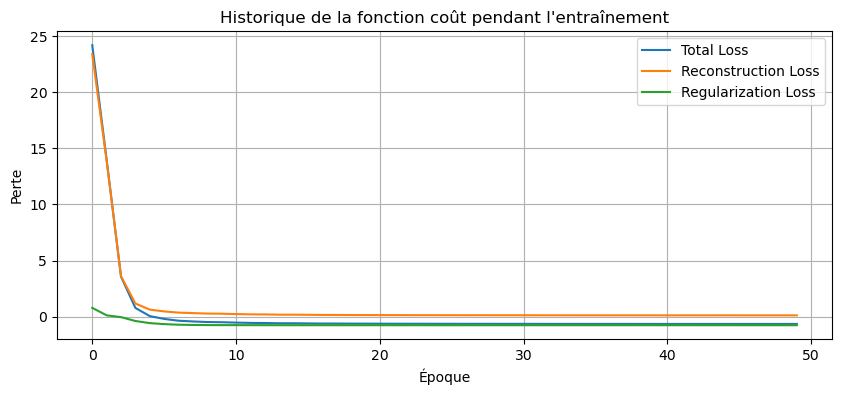

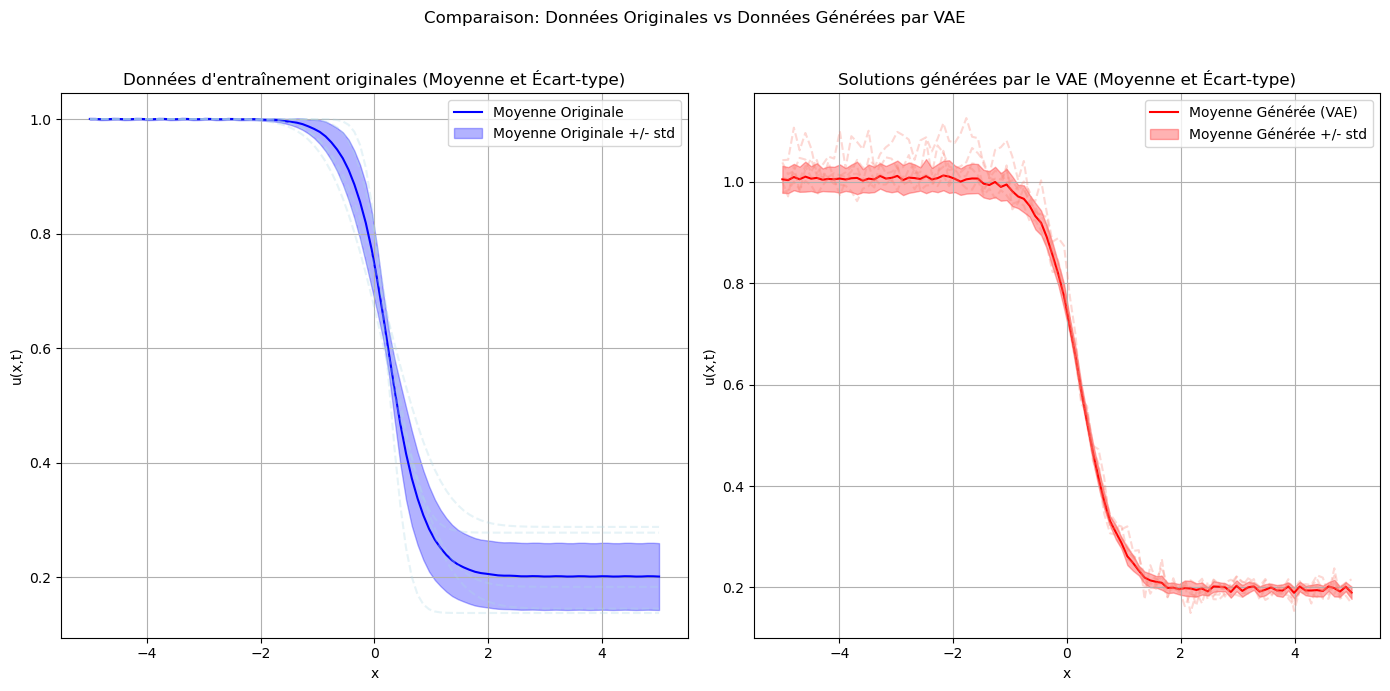

In [25]:
test_vae_method()